## Курсовой проект

1. [Загрузка данных и импорт библиотек](#load_data)
2. [EDA и генерация признаков](#eda_feature_engineering)
3. [Построение датасета для обучения](#train_dataset)
4. [Бейзлайн](#baseline_model)
5. [Построение и сохранение модели](#model)
6. [Приложение](#appendix)

In [1]:
# %%time
# df = dd.read_csv('/Users/rk/Downloads/features.csv', sep='\t').drop(columns=['Unnamed: 0'])
# df['buy_time'] = df['buy_time'].apply(lambda x: dt.datetime.fromtimestamp(x))
# df = df.set_index('id')
# df.head()

In [2]:
# train_df = dd.read_csv('/Users/rk/Downloads/data_train.csv').drop(columns=['Unnamed: 0'])
# train_df['buy_time'] = train_df['buy_time'].apply(lambda x: dt.datetime.fromtimestamp(x))
# train_df = train_df.set_index('id')
# train_df.head()

In [3]:
# %%time
# user_df = dd.merge_asof(train_df, df, left_index=True, right_index=True, by='buy_time', direction='nearest')
# user_df.head(20)

### 1. Загрузка данных и импорт библиотек <a class="anchor" id="load_data"></a>

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import datetime as dt
import sys
import pickle


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix,\
                            log_loss, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier

Загрузим все датасеты необходимые для дальнейшей работы: 
  - train и test датасеты;
  - пользовательские профили.
  
Преобразуем время предложения/покупки в привычные даты.

In [6]:
%%time
features_df = pd.read_csv('/Users/rk/Downloads/features.csv', sep='\t').drop(columns=['Unnamed: 0'])
features_df['buy_time'] = features_df['buy_time'].apply(lambda date: dt.datetime.fromtimestamp(date))
features_df.head()

CPU times: user 5min 4s, sys: 2min 8s, total: 7min 13s
Wall time: 12min 52s


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-15 23:00:00,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,2018-10-14 23:00:00,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,2018-12-23 22:00:00,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,2018-08-12 23:00:00,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,2018-08-05 23:00:00,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [7]:
%%time
train_df = pd.read_csv('/Users/rk/Downloads/data_train.csv').drop(columns=['Unnamed: 0'])
train_df['buy_time'] = train_df['buy_time'].apply(lambda date: dt.datetime.fromtimestamp(date))
# train_df.sort_index(axis=0, inplace=True)
train_df.head()

CPU times: user 1.11 s, sys: 112 ms, total: 1.22 s
Wall time: 1.48 s


,id,vas_id,buy_time,target
0,540968,8.0,2018-09-16 23:00:00,0.0
1,1454121,4.0,2018-07-15 23:00:00,0.0
2,2458816,1.0,2018-08-12 23:00:00,0.0
3,3535012,5.0,2018-09-02 23:00:00,0.0
4,1693214,1.0,2018-09-02 23:00:00,0.0


In [8]:
%%time
test_df = pd.read_csv('/Users/rk/Downloads/data_test.csv').drop(columns=['Unnamed: 0'])
test_df['buy_time'] = test_df['buy_time'].apply(lambda date: dt.datetime.fromtimestamp(date))
# test_df.sort_index(axis=0, inplace=True)
test_df.head()

CPU times: user 97.2 ms, sys: 15.6 ms, total: 113 ms
Wall time: 170 ms


,id,vas_id,buy_time
0,3130519,2.0,2019-01-20 22:00:00
1,2000860,4.0,2019-01-20 22:00:00
2,1099444,2.0,2019-01-06 22:00:00
3,1343255,5.0,2019-01-13 22:00:00
4,1277040,2.0,2019-01-06 22:00:00


### 2. EDA и генерация признаков <a class="anchor" id="eda_feature_engineering"></a>

#### Пользовательские профили

На основе датасета `features` можно сделать вывод, что профиль пользователя описывается 253 обезличенными характеристиками. Можно попробовать провести какой-то базовый анализ этих признаков, что и будет сделано далее, однако с такими вводными сложно делать вывод о том, какие из них могут быть полезнее для моделирования. В данной ситуации на мой взгляд могут быть три подхода:

1. Если позволяют вычислительные мощности на основе существующих характеристик можно нагенерить дополнительные признаки путем арифметических преобразований над парами признаков или логарифмирования. Таким образом еще сильнее увеличить количество признаков, в надежде поймать нелинейные зависимости. Затем можно будет оставить только те, которые покажут свою важность для модели. Однако стоит понимать, что это приведет к значительному увеличению времени расчета и усложнению модели. Я довольно ограничен в вопросе мощностей, поэтому этот подход я пробовать не буду.
2. Использовать все предоставленные признаки, характеризующие пользователя, без изменений.
3. Сократить количество признаков с помощью моделей понижения размерности.

In [9]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4512528 entries, 0 to 4512527
Columns: 255 entries, id to 252
dtypes: datetime64[ns](1), float64(253), int64(1)
memory usage: 8.6 GB


Как видим все признаки заданы вещественными числами. Создадим новые признаки на основе даты составления профиля.

In [10]:
features_df['feat_year'] = features_df['buy_time'].dt.year
features_df['feat_month'] = features_df['buy_time'].dt.month
features_df['feat_day'] = features_df['buy_time'].dt.day
features_df['feat_weekday'] = features_df['buy_time'].dt.dayofweek
features_df['feat_hour'] = features_df['buy_time'].dt.hour
features_df.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,248,249,250,251,252,feat_year,feat_month,feat_day,feat_weekday,feat_hour
0,2013026,2018-07-15 23:00:00,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2018,7,15,6,23
1,2014722,2018-10-14 23:00:00,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-13.832889,-0.694428,-1.175933,-0.45614,0.0,2018,10,14,6,23
2,2015199,2018-12-23 22:00:00,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2018,12,23,6,22
3,2021765,2018-08-12 23:00:00,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-24.832889,-0.694428,-11.175933,-0.45614,1.0,2018,8,12,6,23
4,2027465,2018-08-05 23:00:00,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,92.167111,-0.694428,49.824067,47.54386,0.0,2018,8,5,6,23


Видим, что для некоторых пользователей профиль менялся за время наблюдения.

In [11]:
features_df['id'].value_counts()

1952338    2
1999231    2
734779     2
4008552    2
3628778    2
          ..
240906     1
241614     1
241672     1
241769     1
3521702    1
Name: id, Length: 4362739, dtype: int64

#### Предложения пользователям и отклик

Посмотрим на обучающий датасет по предложениям/покупкам пользователей.

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        831653 non-null  int64         
 1   vas_id    831653 non-null  float64       
 2   buy_time  831653 non-null  datetime64[ns]
 3   target    831653 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 25.4 MB


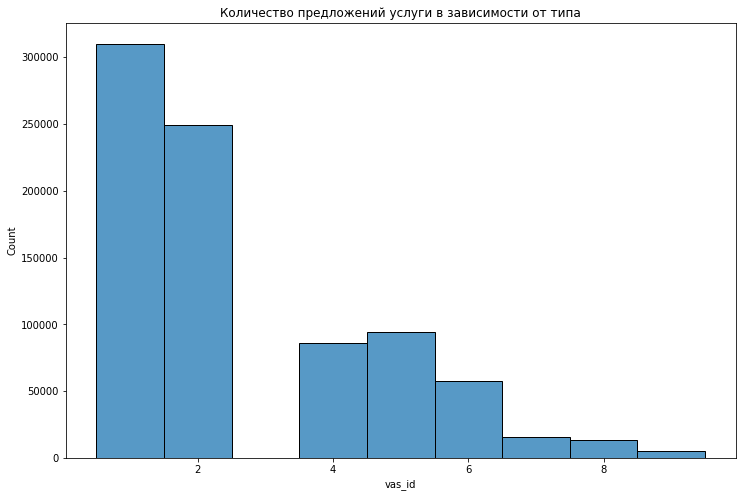

In [13]:
plt.figure(figsize=(12, 8))

sns.histplot(train_df['vas_id'], discrete=True, binwidth=1)
plt.title('Количество предложений услуги в зависимости от типа')
plt.show()

Из графика видно, что в основном предлагаются услуги _1_ и _2_, а услуга _3_ вообще не представлена в датасете.

In [14]:
train_df.vas_id.value_counts()

1.0    310175
2.0    249505
5.0     94085
4.0     85756
6.0     57878
7.0     15432
8.0     13350
9.0      5472
Name: vas_id, dtype: int64

Некоторые пользователям делалось больше одного предложения за наблюдаемый период.

In [15]:
train_df['id'].value_counts()

1347260    3
841367     3
539844     3
859596     3
1681750    3
          ..
4158091    1
1810696    1
300957     1
1195752    1
3022610    1
Name: id, Length: 806613, dtype: int64

Аналогично датасету с пользовательскими профилями создадим дополнительные признаки на основе имеющихся дат.

In [16]:
train_df['offer_year'] = train_df['buy_time'].dt.year
train_df['offer_month'] = train_df['buy_time'].dt.month
train_df['offer_day'] = train_df['buy_time'].dt.day
train_df['offer_weekday'] = train_df['buy_time'].dt.dayofweek
train_df['offer_hour'] = train_df['buy_time'].dt.hour
train_df.head()

,id,vas_id,buy_time,target,offer_year,offer_month,offer_day,offer_weekday,offer_hour
0,540968,8.0,2018-09-16 23:00:00,0.0,2018,9,16,6,23
1,1454121,4.0,2018-07-15 23:00:00,0.0,2018,7,15,6,23
2,2458816,1.0,2018-08-12 23:00:00,0.0,2018,8,12,6,23
3,3535012,5.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23
4,1693214,1.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23


In [17]:
train_df['offer_year'].value_counts()

2018    831653
Name: offer_year, dtype: int64

Все наблюдения в обучающем датасете относятся к 2018 году.

In [18]:
train_df['offer_month'].value_counts()

12    247580
8     146804
9     138238
7     136679
10     88832
11     73520
Name: offer_month, dtype: int64

Так как мы имеем дело с датасетом, в котором присутствуют даты, то, на мой взгляд, будет корректно использовать хронологический подход для разделения датасета на выборки для обучения и валидации. Будем обучаться на периоде с июля по ноябрь, а валидироваться на декабрьских наблюдениях.

In [19]:
MONTH = 12


tdf = train_df[train_df['offer_month'] < MONTH]
tdf.head()

,id,vas_id,buy_time,target,offer_year,offer_month,offer_day,offer_weekday,offer_hour
0,540968,8.0,2018-09-16 23:00:00,0.0,2018,9,16,6,23
1,1454121,4.0,2018-07-15 23:00:00,0.0,2018,7,15,6,23
2,2458816,1.0,2018-08-12 23:00:00,0.0,2018,8,12,6,23
3,3535012,5.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23
4,1693214,1.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23


Рассчитаем количество предложений каждой услуги во время периода обучения, будем использовать это как дополнительный признак при дальнейшем построении модели.

In [20]:
vas_count = tdf.groupby(by='vas_id')['id'].count().reset_index()
vas_count.rename(columns={'id': 'vas_count'}, inplace=True)
train_df = train_df.merge(vas_count, on='vas_id', how='left')
train_df.head()

,id,vas_id,buy_time,target,offer_year,offer_month,offer_day,offer_weekday,offer_hour,vas_count
0,540968,8.0,2018-09-16 23:00:00,0.0,2018,9,16,6,23,12181
1,1454121,4.0,2018-07-15 23:00:00,0.0,2018,7,15,6,23,77870
2,2458816,1.0,2018-08-12 23:00:00,0.0,2018,8,12,6,23,272493
3,3535012,5.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23,43570
4,1693214,1.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23,272493


Аналогичным образом в качестве признака будем использовать количество предложений, которое получил пользователь с июля по ноябрь.

In [21]:
user_count = tdf.groupby(by='id')['vas_id'].count().reset_index()
user_count.rename(columns={'vas_id': 'id_count'}, inplace=True)
train_df = train_df.merge(user_count, on='id', how='left')
train_df.head()

,id,vas_id,buy_time,target,offer_year,offer_month,offer_day,offer_weekday,offer_hour,vas_count,id_count
0,540968,8.0,2018-09-16 23:00:00,0.0,2018,9,16,6,23,12181,1.0
1,1454121,4.0,2018-07-15 23:00:00,0.0,2018,7,15,6,23,77870,1.0
2,2458816,1.0,2018-08-12 23:00:00,0.0,2018,8,12,6,23,272493,1.0
3,3535012,5.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23,43570,1.0
4,1693214,1.0,2018-09-02 23:00:00,0.0,2018,9,2,6,23,272493,1.0


In [22]:
train_df['target'].value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

Данные несбалансированы, поэтому важно выбрать порог для отнесения предсказания к позитивному классу.

### 3. Построение датасета для обучения <a class="anchor" id="train_dataset"></a>

Определим `id` пользователей в качестве индекса в датасетах и отсортируем их по возрастанию для удобства дальнейшего объединения в рамках построения датасета для обучения модели.

In [23]:
features_df = features_df.set_index('id')
features_df.sort_index(axis=0, inplace=True)

train_df = train_df.set_index('id')
train_df.sort_index(axis=0, inplace=True)

Присоединим к датасету с предложениями ближайший по актуальности пользовательский профиль. Такой подход позволит избежать пробемы с пропущенными значениями, однако по моему мнению это может привести к утечке данных, так как возможна ситуация, что мы используем профиль выходящий за пределы периода обучения.

In [24]:
%%time
user_features_df = pd.merge_asof(train_df, features_df, left_index=True, right_index=True,
                                 by='buy_time', direction='nearest')
user_features_df.head()

CPU times: user 30.7 s, sys: 59.4 s, total: 1min 30s
Wall time: 2min 34s


,vas_id,buy_time,target,offer_year,offer_month,offer_day,offer_weekday,offer_hour,vas_count,id_count,...,248,249,250,251,252,feat_year,feat_month,feat_day,feat_weekday,feat_hour
id,,,,,,,,,,,,,,,,,,,,,
2,2.0,2018-12-23 22:00:00,0.0,2018,12,23,6,22,149209,NaN,...,11.167111,7.305572,-12.175933,-0.45614,0.0,2018,12,23,6,22
4,1.0,2018-08-05 23:00:00,0.0,2018,8,5,6,23,272493,1.0,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2018,8,5,6,23
15,1.0,2018-08-12 23:00:00,0.0,2018,8,12,6,23,272493,1.0,...,-4.832889,-0.694428,8.824067,-0.45614,1.0,2018,8,12,6,23
16,2.0,2018-10-28 22:00:00,0.0,2018,10,28,6,22,149209,1.0,...,-23.832889,-0.694428,-12.175933,-0.45614,0.0,2018,10,28,6,22
29,1.0,2018-08-05 23:00:00,0.0,2018,8,5,6,23,272493,1.0,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2018,8,5,6,23


Оценим долю пропущенных значений в признаках.

In [25]:
print(f'Процент признаков которые принимают null-значения? - '
      f'{float((user_features_df.isnull().sum() > 0).sum()/user_features_df.shape[1]*100):.2f}%.')

Процент признаков которые принимают null-значения? - 0.37%.


Будем использовать методы библиотеки `sklearn` для заполнения пропусков.

### 4. Бейзлайн <a class="anchor" id="baseline_model"></a>

Построим baseline модель на базе логистической регрессии.

In [26]:
cols_to_drop = ['target', 'buy_time']

y = user_features_df['target']
X = user_features_df.drop(cols_to_drop, axis=1)

Разделим выборку на две части: для обучения и валидации. Будем придерживаться ранее выбранного подхода - обучение на наблюдениях с июля по ноябрь, валидация на декабрьских данных.

In [27]:
RANDOM_STATE = 42

y_train = user_features_df.loc[user_features_df['offer_month'] < MONTH, 'target']
X_train = user_features_df[user_features_df['offer_month'] < MONTH].drop(cols_to_drop, axis=1)

y_test = user_features_df.loc[user_features_df['offer_month'] >= MONTH, 'target']
X_test = user_features_df[user_features_df['offer_month'] >= MONTH].drop(cols_to_drop, axis=1)


print("Train")
print(y_train.value_counts()/y_train.shape[0])
print("\nTest")
print(y_test.value_counts()/y_test.shape[0])

Train
0.0    0.934967
1.0    0.065033
Name: target, dtype: float64

Test
0.0    0.910324
1.0    0.089676
Name: target, dtype: float64


Теперь построим пайплайн для baseline модели и обучим ее, а затем оценим качество.

In [28]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [29]:
columns = X_train.columns.tolist()

columns_prep_pipeline = make_pipeline(
    ColumnSelector(columns=columns),
    SimpleImputer(),
    StandardScaler()
)

baseline_model = make_pipeline(
    columns_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
)

Обучим модель и посчитаем значение интересующей нас метрики.

In [30]:
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['vas_id',
                                                          'offer_year',
                                                          'offer_month',
                                                          'offer_day',
                                                          'offer_weekday',
                                                          'offer_hour',
                                                          'vas_count',
                                                          'id_count', '0', '1',
                                                          '2', '3', '4', '5',
                                                          '6', '7', '8', '9',
                                                          '10', '11', '12',
                                                          '13', '14', '15',
                             

In [31]:
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
numerator = 2 * recall * precision
denom = recall + precision
f1score = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))

# найдем порог, при котором достигается максимальное значение метрики f1_score
ix = np.argmax(f1score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f1score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.368653, F-Score=0.378, Precision=0.270, Recall=0.627


In [33]:
y_pred = (y_pred_proba > thresholds[ix]) + 0
f1_score(y_test, y_pred, average='macro')

0.6344797635663448

### 5. Построение модели <a class="anchor" id="model"></a>

Теперь проведем более глубокий анализ признаков и попробуем разные модели для того, чтобы улучшить предсказания.

Начнем с того, что попробуем определить тип признаков, определяющих профиль пользователя.

In [34]:
cols_to_drop = ['target', 'buy_time', 
                'feat_year', 'feat_month', 'feat_day', 'feat_weekday', 'feat_hour', 
                'offer_year', 'offer_month',
                'id_count', 'vas_count'
               ]

y = user_features_df['target']
X = user_features_df.drop(cols_to_drop, axis=1)

MONTH = 12
RANDOM_STATE = 42

y_train = user_features_df.loc[user_features_df['offer_month'] < MONTH, 'target']
X_train = user_features_df[user_features_df['offer_month'] < MONTH].drop(cols_to_drop, axis=1)

y_test = user_features_df.loc[user_features_df['offer_month'] >= MONTH, 'target']
X_test = user_features_df[user_features_df['offer_month'] >= MONTH].drop(cols_to_drop, axis=1)

In [35]:
X_train.head()

,vas_id,offer_day,offer_weekday,offer_hour,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
4,1.0,5,6,23,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
15,1.0,12,6,23,49.150029,10.390888,63.159214,11.993202,57.741754,-9.11179,...,-950.373846,-593.770792,-24.996269,-37.630448,81.252276,-4.832889,-0.694428,8.824067,-0.45614,1.0
16,2.0,28,6,22,42.570029,138.740888,28.629214,86.133202,23.211754,65.02821,...,1394.626154,1272.229208,-22.996269,-36.630448,-6.747724,-23.832889,-0.694428,-12.175933,-0.45614,0.0
29,1.0,5,6,23,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
30,7.0,14,6,23,-96.799971,-408.179112,-81.080786,-426.886798,-75.908246,-435.28179,...,13177.626154,3432.229208,-20.996269,-32.630448,-34.747724,-4.832889,-0.694428,-4.175933,-0.45614,0.0


In [36]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

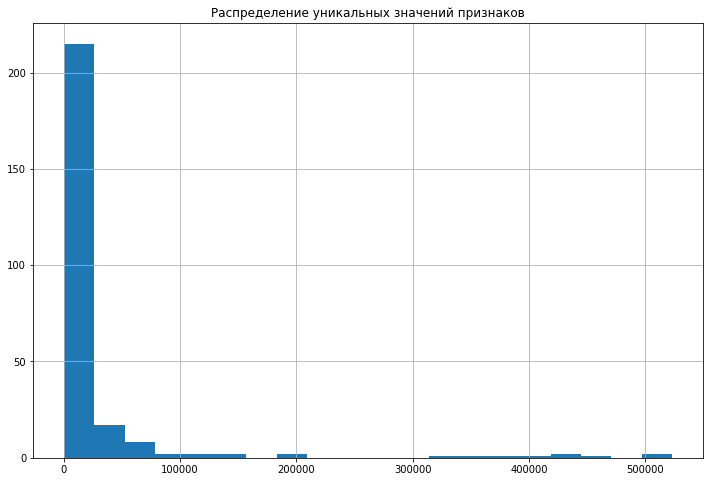

In [37]:
plt.figure(figsize=(12, 8))
plt.title("Распределение уникальных значений признаков")
X_nunique.hist(bins=20)
plt.show()

Как видим большинство признаков принимает относительно небольшое количество уникальных значений.

Оценим общее количество признаков.

In [38]:
f_all = set(X_nunique.index.tolist())
len(f_all)

257

Найдем количество признаков, которые неизменны для всех наблюдений, а значит не дают никакой информации для предсказаний - их нужно будет исключить перед построеним модели.

In [39]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
f_other = f_all - f_const
len(f_const)

6

Теперь определим бинарные признаки.

In [40]:
f_binary = set(X_nunique.loc[f_other][X_nunique == 2].index.tolist())
f_other -= f_binary
len(f_binary)

21

В качестве категориальных будем рассматривать такие признаки из оставшихся, которые принимают не более 10 уникальных значений.

In [41]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_other -= f_categorical
len(f_categorical)

10

Все остальные признаки будет рассматривать как вещественные.

In [42]:
f_numerical = f_other
len(f_numerical)

220

Исключим неизменные признаки и построим пайплайн для новой модели.

In [43]:
f_ok = f_all - f_const
len(f_ok)

251

Попробуем построить модель на основе `CatBoost`.

In [44]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns].astype('str')
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [45]:
cat_columns_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numerical)
        )),
        ("categorical_features", make_pipeline(
            FeatureSelector(f_categorical),
        )),
        ("boolean_features", make_pipeline(
            FeatureSelector(f_binary),
        ))
    ])
)

cb_baseline_model = make_pipeline(
    cat_columns_prep_pipeline,
    CatBoostClassifier(random_state=RANDOM_STATE, 
                       cat_features=list(range(len(f_ok))[-len(f_categorical | f_binary):]))
)

In [46]:
cb_baseline_model.fit(X_train, y_train)

Learning rate set to 0.156392
0:	learn: 0.4975918	total: 1.52s	remaining: 25m 17s
1:	learn: 0.3786006	total: 2.62s	remaining: 21m 47s
2:	learn: 0.3075062	total: 3.65s	remaining: 20m 11s
3:	learn: 0.2356676	total: 4.43s	remaining: 18m 22s
4:	learn: 0.1965375	total: 5.14s	remaining: 17m 2s
5:	learn: 0.1767889	total: 5.78s	remaining: 15m 57s
6:	learn: 0.1629945	total: 6.45s	remaining: 15m 15s
7:	learn: 0.1547176	total: 7.22s	remaining: 14m 55s
8:	learn: 0.1495494	total: 7.88s	remaining: 14m 27s
9:	learn: 0.1459648	total: 8.54s	remaining: 14m 5s
10:	learn: 0.1438973	total: 9.06s	remaining: 13m 34s
11:	learn: 0.1422829	total: 9.59s	remaining: 13m 9s
12:	learn: 0.1414843	total: 10.2s	remaining: 12m 50s
13:	learn: 0.1406742	total: 10.7s	remaining: 12m 36s
14:	learn: 0.1402805	total: 11.4s	remaining: 12m 31s
15:	learn: 0.1398219	total: 12.2s	remaining: 12m 31s
16:	learn: 0.1397614	total: 13s	remaining: 12m 30s
17:	learn: 0.1396270	total: 13.5s	remaining: 12m 19s
18:	learn: 0.1394642	total: 14.

154:	learn: 0.1366415	total: 1m 46s	remaining: 9m 41s
155:	learn: 0.1366123	total: 1m 47s	remaining: 9m 40s
156:	learn: 0.1365865	total: 1m 48s	remaining: 9m 40s
157:	learn: 0.1365700	total: 1m 48s	remaining: 9m 39s
158:	learn: 0.1365490	total: 1m 49s	remaining: 9m 38s
159:	learn: 0.1365138	total: 1m 50s	remaining: 9m 37s
160:	learn: 0.1364943	total: 1m 50s	remaining: 9m 37s
161:	learn: 0.1364805	total: 1m 51s	remaining: 9m 36s
162:	learn: 0.1364498	total: 1m 52s	remaining: 9m 35s
163:	learn: 0.1364294	total: 1m 52s	remaining: 9m 34s
164:	learn: 0.1364260	total: 1m 53s	remaining: 9m 33s
165:	learn: 0.1364097	total: 1m 54s	remaining: 9m 33s
166:	learn: 0.1364013	total: 1m 55s	remaining: 9m 34s
167:	learn: 0.1363766	total: 1m 56s	remaining: 9m 35s
168:	learn: 0.1363590	total: 1m 56s	remaining: 9m 34s
169:	learn: 0.1363539	total: 1m 57s	remaining: 9m 33s
170:	learn: 0.1363362	total: 1m 58s	remaining: 9m 32s
171:	learn: 0.1363257	total: 1m 58s	remaining: 9m 31s
172:	learn: 0.1363234	total:

307:	learn: 0.1342498	total: 3m 30s	remaining: 7m 52s
308:	learn: 0.1342463	total: 3m 30s	remaining: 7m 51s
309:	learn: 0.1342388	total: 3m 31s	remaining: 7m 50s
310:	learn: 0.1342291	total: 3m 32s	remaining: 7m 49s
311:	learn: 0.1342111	total: 3m 32s	remaining: 7m 49s
312:	learn: 0.1341867	total: 3m 33s	remaining: 7m 48s
313:	learn: 0.1341768	total: 3m 34s	remaining: 7m 47s
314:	learn: 0.1341516	total: 3m 34s	remaining: 7m 47s
315:	learn: 0.1341275	total: 3m 35s	remaining: 7m 46s
316:	learn: 0.1341162	total: 3m 36s	remaining: 7m 45s
317:	learn: 0.1341159	total: 3m 36s	remaining: 7m 44s
318:	learn: 0.1341129	total: 3m 37s	remaining: 7m 44s
319:	learn: 0.1340935	total: 3m 38s	remaining: 7m 43s
320:	learn: 0.1340650	total: 3m 38s	remaining: 7m 43s
321:	learn: 0.1340355	total: 3m 39s	remaining: 7m 42s
322:	learn: 0.1340199	total: 3m 40s	remaining: 7m 41s
323:	learn: 0.1340145	total: 3m 40s	remaining: 7m 41s
324:	learn: 0.1340082	total: 3m 41s	remaining: 7m 40s
325:	learn: 0.1339904	total:

460:	learn: 0.1320267	total: 5m 15s	remaining: 6m 8s
461:	learn: 0.1320166	total: 5m 15s	remaining: 6m 7s
462:	learn: 0.1320159	total: 5m 16s	remaining: 6m 7s
463:	learn: 0.1319993	total: 5m 17s	remaining: 6m 6s
464:	learn: 0.1319895	total: 5m 17s	remaining: 6m 5s
465:	learn: 0.1319782	total: 5m 18s	remaining: 6m 5s
466:	learn: 0.1319773	total: 5m 19s	remaining: 6m 4s
467:	learn: 0.1319620	total: 5m 19s	remaining: 6m 3s
468:	learn: 0.1319353	total: 5m 20s	remaining: 6m 2s
469:	learn: 0.1319130	total: 5m 21s	remaining: 6m 2s
470:	learn: 0.1319001	total: 5m 21s	remaining: 6m 1s
471:	learn: 0.1318892	total: 5m 22s	remaining: 6m
472:	learn: 0.1318753	total: 5m 23s	remaining: 5m 59s
473:	learn: 0.1318723	total: 5m 23s	remaining: 5m 59s
474:	learn: 0.1318632	total: 5m 24s	remaining: 5m 58s
475:	learn: 0.1318388	total: 5m 25s	remaining: 5m 57s
476:	learn: 0.1318135	total: 5m 25s	remaining: 5m 57s
477:	learn: 0.1317970	total: 5m 26s	remaining: 5m 56s
478:	learn: 0.1317749	total: 5m 27s	remaini

613:	learn: 0.1300304	total: 6m 55s	remaining: 4m 21s
614:	learn: 0.1300121	total: 6m 56s	remaining: 4m 20s
615:	learn: 0.1300085	total: 6m 57s	remaining: 4m 20s
616:	learn: 0.1299789	total: 6m 58s	remaining: 4m 19s
617:	learn: 0.1299621	total: 6m 59s	remaining: 4m 19s
618:	learn: 0.1299427	total: 6m 59s	remaining: 4m 18s
619:	learn: 0.1299409	total: 7m	remaining: 4m 17s
620:	learn: 0.1299289	total: 7m 1s	remaining: 4m 16s
621:	learn: 0.1299144	total: 7m 1s	remaining: 4m 16s
622:	learn: 0.1299003	total: 7m 2s	remaining: 4m 15s
623:	learn: 0.1298887	total: 7m 3s	remaining: 4m 14s
624:	learn: 0.1298660	total: 7m 3s	remaining: 4m 14s
625:	learn: 0.1298615	total: 7m 4s	remaining: 4m 13s
626:	learn: 0.1298397	total: 7m 5s	remaining: 4m 12s
627:	learn: 0.1298268	total: 7m 5s	remaining: 4m 12s
628:	learn: 0.1298092	total: 7m 6s	remaining: 4m 11s
629:	learn: 0.1298072	total: 7m 7s	remaining: 4m 10s
630:	learn: 0.1297841	total: 7m 8s	remaining: 4m 10s
631:	learn: 0.1297584	total: 7m 8s	remainin

767:	learn: 0.1279729	total: 8m 49s	remaining: 2m 39s
768:	learn: 0.1279609	total: 8m 50s	remaining: 2m 39s
769:	learn: 0.1279395	total: 8m 50s	remaining: 2m 38s
770:	learn: 0.1279350	total: 8m 51s	remaining: 2m 37s
771:	learn: 0.1279213	total: 8m 52s	remaining: 2m 37s
772:	learn: 0.1279044	total: 8m 52s	remaining: 2m 36s
773:	learn: 0.1279043	total: 8m 53s	remaining: 2m 35s
774:	learn: 0.1279019	total: 8m 53s	remaining: 2m 35s
775:	learn: 0.1278894	total: 8m 54s	remaining: 2m 34s
776:	learn: 0.1278704	total: 8m 55s	remaining: 2m 33s
777:	learn: 0.1278701	total: 8m 56s	remaining: 2m 32s
778:	learn: 0.1278565	total: 8m 56s	remaining: 2m 32s
779:	learn: 0.1278434	total: 8m 57s	remaining: 2m 31s
780:	learn: 0.1278315	total: 8m 58s	remaining: 2m 30s
781:	learn: 0.1278284	total: 8m 59s	remaining: 2m 30s
782:	learn: 0.1278167	total: 8m 59s	remaining: 2m 29s
783:	learn: 0.1278104	total: 9m	remaining: 2m 28s
784:	learn: 0.1278042	total: 9m 1s	remaining: 2m 28s
785:	learn: 0.1277819	total: 9m 2

920:	learn: 0.1260165	total: 10m 36s	remaining: 54.6s
921:	learn: 0.1260052	total: 10m 37s	remaining: 53.9s
922:	learn: 0.1259937	total: 10m 37s	remaining: 53.2s
923:	learn: 0.1259906	total: 10m 38s	remaining: 52.5s
924:	learn: 0.1259822	total: 10m 39s	remaining: 51.8s
925:	learn: 0.1259727	total: 10m 40s	remaining: 51.1s
926:	learn: 0.1259607	total: 10m 40s	remaining: 50.5s
927:	learn: 0.1259543	total: 10m 41s	remaining: 49.8s
928:	learn: 0.1259437	total: 10m 41s	remaining: 49.1s
929:	learn: 0.1259374	total: 10m 42s	remaining: 48.4s
930:	learn: 0.1259202	total: 10m 43s	remaining: 47.7s
931:	learn: 0.1259059	total: 10m 44s	remaining: 47s
932:	learn: 0.1259035	total: 10m 44s	remaining: 46.3s
933:	learn: 0.1258919	total: 10m 45s	remaining: 45.6s
934:	learn: 0.1258733	total: 10m 45s	remaining: 44.9s
935:	learn: 0.1258583	total: 10m 46s	remaining: 44.2s
936:	learn: 0.1258428	total: 10m 47s	remaining: 43.5s
937:	learn: 0.1258339	total: 10m 47s	remaining: 42.8s
938:	learn: 0.1258240	total: 1

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [47]:
y_pred_proba = cb_baseline_model.predict_proba(X_test)[:, 1]

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
numerator = 2 * recall * precision
denom = recall + precision
f1score = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))

# найдем порог, при котором достигается максимальное значение метрики f1_score
ix = np.argmax(f1score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f1score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.414111, F-Score=0.464, Precision=0.378, Recall=0.602


In [49]:
y_pred = (y_pred_proba > thresholds[ix]) + 0
f1_score(y_test, y_pred, average='macro')

0.6968218424994674

Видим, что удалось улучшить метрику по сравнению с бейзлайн моделью. Теперь построим классификатор на основе градиентного бустинга из `sklearn`.

In [50]:
columns_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numerical)
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ]),
    SimpleImputer(),
)

model = make_pipeline(
    columns_prep_pipeline,
    GradientBoostingClassifier(random_state=RANDOM_STATE, max_features=70)
)

In [51]:
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [52]:
y_pred_proba_gb = model.predict_proba(X_test)[:, 1]

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_gb)
numerator = 2 * recall * precision
denom = recall + precision
f1score = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))

# найдем порог, при котором достигается максимальное значение метрики f1_score
ix = np.argmax(f1score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f1score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.293785, F-Score=0.567, Precision=0.408, Recall=0.927


In [54]:
y_pred = (y_pred_proba_gb > thresholds[ix]) + 0
f1_score(y_test, y_pred, average='macro')

0.7461506010607784

Видим, что удалось добиться повышения значения требуемой метрики. Сохраним модель в формате pickle.

In [55]:
pickle.dump(model, open('model.pkl', 'wb'))

### 6. Приложение <a class="anchor" id="appendix"></a>

In [84]:
%%time
test_df = pd.read_csv('/Users/rk/Downloads/data_test.csv').drop(columns=['Unnamed: 0'])
initial_test_df = test_df.copy()
# test_df['buy_time'] = test_df['buy_time'].apply(lambda date: dt.datetime.fromtimestamp(date))
# test_df.sort_index(axis=0, inplace=True)
test_df.head()

CPU times: user 28.8 ms, sys: 53.1 ms, total: 81.9 ms
Wall time: 108 ms


,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


In [85]:
test_df = test_df.set_index('id')
test_df.sort_index(axis=0, inplace=True)
buy_times = test_df['buy_time']

test_df['buy_time'] = test_df['buy_time'].apply(lambda date: dt.datetime.fromtimestamp(date))
test_df['offer_day'] = test_df['buy_time'].dt.day
test_df['offer_weekday'] = test_df['buy_time'].dt.dayofweek
test_df['offer_hour'] = test_df['buy_time'].dt.hour
test_df.head()

,vas_id,buy_time,offer_day,offer_weekday,offer_hour
id,,,,,
55,2.0,2019-01-13 22:00:00,13,6,22
64,4.0,2019-01-20 22:00:00,20,6,22
151,2.0,2019-01-13 22:00:00,13,6,22
274,4.0,2019-01-20 22:00:00,20,6,22
274,2.0,2019-01-13 22:00:00,13,6,22


In [86]:
%%time
test_features_df = pd.merge_asof(test_df, features_df, left_index=True, right_index=True,
                                 by='buy_time', direction='nearest')
test_features_df.head()

CPU times: user 26.1 s, sys: 1min, total: 1min 26s
Wall time: 2min 22s


,vas_id,buy_time,offer_day,offer_weekday,offer_hour,0,1,2,3,4,...,248,249,250,251,252,feat_year,feat_month,feat_day,feat_weekday,feat_hour
id,,,,,,,,,,,,,,,,,,,,,
55,2.0,2019-01-13 22:00:00,13,6,22,-96.799971,-166.599112,-110.740786,-219.206798,-116.158246,...,-22.832889,-0.694428,-12.175933,-0.45614,1.0,2019,1,13,6,22
64,4.0,2019-01-20 22:00:00,20,6,22,-96.799971,-407.009112,-110.740786,-459.616798,-116.158246,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2019,1,20,6,22
151,2.0,2019-01-13 22:00:00,13,6,22,-20.989971,-147.029112,-34.930786,-199.636798,-40.348246,...,109.167111,-0.694428,-12.175933,-0.45614,0.0,2019,1,13,6,22
274,4.0,2019-01-20 22:00:00,20,6,22,265.700029,-43.599112,251.759214,-83.706798,246.341754,...,-24.832889,-0.694428,-12.175933,0.54386,0.0,2019,1,20,6,22
274,2.0,2019-01-13 22:00:00,13,6,22,-20.989971,-116.859112,-34.930786,-169.466798,-40.348246,...,-21.832889,-0.694428,-12.175933,-0.45614,0.0,2019,1,13,6,22


In [87]:
y_pred = model.predict_proba(test_features_df)[:, 1]

In [89]:
test_df['target'] = y_pred
test_df = test_df.reset_index().drop(['offer_day', 'offer_weekday', 'offer_hour'], axis=1)
test_df.head()

,id,vas_id,buy_time,target
0,55,2.0,2019-01-13 22:00:00,0.046141
1,64,4.0,2019-01-20 22:00:00,0.625106
2,151,2.0,2019-01-13 22:00:00,0.097778
3,274,4.0,2019-01-20 22:00:00,0.504774
4,274,2.0,2019-01-13 22:00:00,0.099829


In [92]:
test_df['buy_time'] = buy_times.values
test_df.head()
# answers_df = initial_test_df.merge(test_df, on=['id', 'vas_id', 'buy_time'], how='left')
# answers_df.head()

,id,vas_id,buy_time,target
0,55,2.0,1547413200,0.046141
1,64,4.0,1548018000,0.625106
2,151,2.0,1547413200,0.097778
3,274,4.0,1548018000,0.504774
4,274,2.0,1547413200,0.099829


In [95]:
initial_test_df[initial_test_df['id'] == 274]

,id,vas_id,buy_time
551,274,2.0,1547413200
552,274,4.0,1548018000


In [73]:
with open('model2.pkl', 'wb') as f:
    pickle.dump(model, f)

In [75]:
import dill

with open('model.dill', 'wb') as f:
    dill.dump(model, f)

In [62]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1_macro'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [63]:
kfold_cv = KFold(n_splits=3)

param_grid = {
    'gradientboostingclassifier__max_features': [50, 70],
    'gradientboostingclassifier__max_depth': [5, 7],
#     'gradientboostingclassifier__learning_rate': [0.05, 0.1],
#     'gradientboostingclassifier__n_estimators': [50, 100, 150],
}

lg_gsc = run_grid_search(model, X_train, y_train, param_grid, kfold_cv)

Best f1_macro score: 0.71

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 70}

Grid scores on development set:

0.690 (+/-0.029) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__max_features': 50}
0.707 (+/-0.034) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__max_features': 70}
0.710 (+/-0.040) for {'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 50}
0.713 (+/-0.044) for {'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 70}



In [69]:
columns_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numerical)
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ]),
    SimpleImputer(),
)

model = make_pipeline(
    columns_prep_pipeline,
    GradientBoostingClassifier(random_state=RANDOM_STATE, max_features=50, max_depth=7)
)

In [70]:
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [71]:
y_pred_proba_gb = model.predict_proba(X_test)[:, 1]

In [72]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_gb)
numerator = 2 * recall * precision
denom = recall + precision
f1score = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))

# найдем порог, при котором достигается максимальное значение метрики f1_score
ix = np.argmax(f1score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f1score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.279914, F-Score=0.564, Precision=0.408, Recall=0.911


In [73]:
y_pred = (y_pred_proba_gb > thresholds[ix]) + 0
f1_score(y_test, y_pred, average='macro')

0.7450191879120089

In [39]:
param_grid = {
    "gradientboostingclassifier__max_features": [70, 90, 110],
    'gradientboostingclassifier__subsample': [0.3, 0.5, 0.7],
}

lg_gsc = run_grid_search(baseline_model, X_train, y_train, param_grid, kfold_cv)
# Best f1_macro score: 0.72

# Best parameters set found on development set:

# {'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.7}

# Grid scores on development set:

# 0.704 (+/-0.002) for {'gradientboostingclassifier__max_features': 70, 'gradientboostingclassifier__subsample': 0.3}
# 0.711 (+/-0.007) for {'gradientboostingclassifier__max_features': 70, 'gradientboostingclassifier__subsample': 0.5}
# 0.711 (+/-0.007) for {'gradientboostingclassifier__max_features': 70, 'gradientboostingclassifier__subsample': 0.7}
# 0.714 (+/-0.003) for {'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.3}
# 0.710 (+/-0.005) for {'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.5}
# 0.719 (+/-0.013) for {'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.7}
# 0.715 (+/-0.004) for {'gradientboostingclassifier__max_features': 110, 'gradientboostingclassifier__subsample': 0.3}
# 0.716 (+/-0.011) for {'gradientboostingclassifier__max_features': 110, 'gradientboostingclassifier__subsample': 0.5}
# 0.715 (+/-0.008) for {'gradientboostingclassifier__max_features': 110, 'gradientboostingclassifier__subsample': 0.7}


Best f1_macro score: 0.72

Best parameters set found on development set:

{'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.7}

Grid scores on development set:

0.704 (+/-0.002) for {'gradientboostingclassifier__max_features': 70, 'gradientboostingclassifier__subsample': 0.3}
0.711 (+/-0.007) for {'gradientboostingclassifier__max_features': 70, 'gradientboostingclassifier__subsample': 0.5}
0.711 (+/-0.007) for {'gradientboostingclassifier__max_features': 70, 'gradientboostingclassifier__subsample': 0.7}
0.714 (+/-0.003) for {'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.3}
0.710 (+/-0.005) for {'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.5}
0.719 (+/-0.013) for {'gradientboostingclassifier__max_features': 90, 'gradientboostingclassifier__subsample': 0.7}
0.715 (+/-0.004) for {'gradientboostingclassifier__max_features': 110, 'gradientboostingclassifier__s